# Running HYSPLIT using Python and batch code
For questions about running this code, please email kripa.vyas@mail.mcgill.ca

This manual provides a guide to the code developed for analyzing extratropical cyclones and their moisture sources using HYSPLIT trajectory modeling, ERA5 reanalysis data, and geospatial filtering techniques. This code is designed to identify and trace precipitating air parcels, evaluate their moisture uptake sources, and generate trajectory-based diagnostics in line with the paper Sources and Transport Pathways of Precipitating Waters in Cold-Season Deep North Atlantic Cyclones (Papritz, 2021) – which I will refer to as “the Papritz paper” moving forward. This manual assumes you are a little familiar with the software HYSPLIT (for troubleshooting), a good resource for questions is the tutorial (https://www.ready.noaa.gov/documents/Tutorial/html/index.html)

The overall goal of the project was to better understand where Arctic storms acquire their moisture by using Lagrangian back-trajectory methods. The code performs the following functions:
-	Storm track analysis: parses storm position data to identify locations relevant to the study
-	Parcel selection: searches for nearby air parcels that contributed to precipitation along the storm path using thresholds for specific humidity, cloud water content, and precipitation rate. 
-	Trajectory initialization: uses parcels to create HYSPLIT CONTROL files that drive backward trajectory simulations from multiple vertical levels. 
-	Trajectory processing: reads and parses tdump files into labeled formats for analysis, parcel tracking, and computation
-	Moisture uptake detection: identifies times and locations along each trajectory where significant increases in specific humidity occur, based on thresholds defined in the Papritz paper.

This manual is intended for future users or any researchers seeking to replicate or extend the workflow. 


## Understanding and organizing files

### Understanding this ZIP file
Within this zip file, there are a few instructional documents. The README.txt file also includes this information. The contents are:
-	main_code.ipynb: a python notebook with all the python functions with markdown explanations, the content of the markdown cells is very similar to this manual so you do not need to read both for a clear picture. Information about the batch files is not here. 
-	code_functions.py: a python file that holds just the functions but no markdown explanations. You can identify what sections of the code correspond to this manual using the comments.
-	run_hysplit_multilevel.bat: a batch file that allows HYSPLIT runs for multiple levels of one storm in succession
-	run_hysplit_singlelevel.bat: a batch file that allows HYSPLIT runs for a single level of a storm
-	ASCDATA.CFG: a ASCII file that contains gridded land-use, terrain, and roughness length data for HYSPLIT. 

In both python codes, I have included docstrings and comments to help you understand the functions. Please read them carefully. 


### Organizing your files
For the python functions to work as is, your code should be in the same directory as your storm CSVs, CONTROL files, etc. You can store the ERA5 data on a hard drive. If this is not the case, please carefully change the filepaths in the functions. Here is the internal file structure that you will have if you were examining one storm (SID = 13, 2003/02):

```
.
├── project
│   ├── main_code.ipynb
│   ├── storm13_200302.csv
│   └── hysplit_info
│       ├── metdata
│       │   ├── RP200302.gbl
│       │   └── RP200301.gbl
│       ├── storm13_200302
│       │   └── height1500
│       │       ├── ASCDATA.CFG
│       │       ├── traj_files_200302.txt
│       │       ├── control_names_200302.txt
│       │       ├── CONTROL_200302day02_hour09_0
│       │       ├── CONTROL_200301day31_hour21_1
│       │       ├── ...
│       │       └── output
│       │           ├── tdump_200302day02_hour09_0
│       │           ├── tdump_200301day31_hour21_1
│       │           └── ...
│       └── traj_data_storm13_200302
│           ├── moisture_uptake_storm13_height1500m.csv
│           └── traj_storm13_height1500m.npz 
└── D:/ (hard drive)
    ├── ERA5_storm13_2003
    │   ├── HumidityCWC_200301_day27to31.nc
    │   ├── HumidityCWC_200302_day1to6.nc
    │   ├── precip_SST_SLP_200302_day27to30.nc
    │   └── precip_SST_SLP_200302_day1to6.nc
    └── CycloneTracking
        └── 13_2E5R
            └── BBox10
                └── AggregationSystem
                    ├── EASE2_N0_25km_GenesisRegions.nc
                    └── CSVSystem
                        ├── 2003
                        │   ├── System13_2E5R_BBox10_200302.csv
                        │   └── ...
                        └── ...
```

## Using this code
Using this code is fairly straightforward. In this section, I will tell you the order of operations and a few tips. 

This code can be run sequentially. After downloading the nc files and running all the helper functions, you can run the precipitating parcels code which will also create the CONTROL files for HYSPLIT. After running HYSPLIT using the batch code, you can load the data and save it using the following functions. Finally, you can find the moisture uptake regions. 

Your code can get messy if you are running several storms. For this reason, I suggest defining the nc_paths dictionaries (see subsection 'Accessing nc files' for info) near the top of the code where you load the libraries and the arctic mask. This makes it so you have it in an easily visible place and you only have one version of each dictionary. Additionally, it is helpful to define a list of tuples with the storm identifiers and putting that at the top of the code as well. You can loop through this list for a lot of the functions, making it fast to run things with minimal rewriting. This is an example of what it may look like:

`STORM_INFO = [(13, 2003, 2, nc_paths_2003, 2), (24, 1995, 1, nc_paths_1995, 1), ...]`

Each tuple represents a storm's (SID, year, month, nc_path variable, metdata_number), in that order. Thus, when you run a function like find_precipitating_parcels, you can use a code block like
```python 
radius, level = 1200, 1500
for info in STORM_INFO:
    SID, YEAR, MONTH, nc_path, met_num = info
    p = find_precipitating_parcels(SID, YEAR, MONTH, level, nc_path, met_num, radius)
```
to avoid retyping information. Finally, you can also put the function `get_dataset_for_time` (see subsection 'Accessing nc files') with the storm information list and nc_paths dictionaries. It is used in multiple functions and will likely be helpful later in the project. This means you won't have to find it again when your code is long.

My most common error was with accessing files incorrectly or overwriting files. Be careful in changing directory and filenames in each function to match your file structure and where you want the files to go. The variables that you need to change should be mentioned in the docstrings but give the function a read-through to make sure you're caught all the instances. 

In [1]:
# ~ import ~
# === Standard Library ===
import glob
import os

# === Third-Party Packages ===
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import netCDF4 as nc
from geopy.distance import geodesic
from pyproj import Transformer
import math as math
from matplotlib import cm, colors
import cartopy.crs as ccrs
from scipy.ndimage import uniform_filter
import cartopy.feature as cfeature
import matplotlib.patheffects as pe

In [ ]:
# uploading the arctic mask 
# note that you arctic mask may not be saved in the same place 
f = nc.Dataset('D:/CycloneTracking/13_2E5R/BBox10/AggregationSystem/EASE2_N0_25km_GenesisRegions.nc')
CAO2 = np.flipud(f.variables['CAO2'][:])

x_mask = f.variables['x'][:]
y_mask = f.variables['y'][:] 

x_grid, y_grid = np.meshgrid(x_mask, y_mask)
transformer = Transformer.from_crs(6931, 4326) #3031 is arctic polar projection, 4326 is the standard code for lat and lon
lat_mask, lon_mask = transformer.transform(x_grid, y_grid) # lat and lon produced from transformer
lat_mask, lon_mask = np.flipud(lat_mask), np.flipud(lon_mask)

## Saving a specific storm in a CSV
The save_storm_csv function extracts and saves trajectory tracking data for a specific storm (identified by its SID, year, month) from a larger CSV file containing multiple storms. It reads the fill dataset from the specified folderpath, filters out rows with missing values, and isolates the subset of data corresponding to the desired storm ID. The resulting storm-specific data includes the storm’s position, time, and cartesian coordinates and this is saved to a new CSV file in the local directory. This means you won’t have to open a massive CSV every time you want to find information about this particular storm, which is useful for analysis. 

Some common errors that this function may throw (and their solutions) are:
-	PermissionError: you may already have a file saved with this name in the same location, please move/rename/delete the existing file and try again
-	ValueError: the delimiter may not match what you have in your large CSV. Try " " or "\t", which are both common options. 
-	OSError: check the filename that it mentions in the error message, is that the file that holds the data for that storm? You may have to adjust the folderpath.


In [ ]:
folderpath = "D:/CycloneTracking/13_2E5R/BBox10/AggregationSystem/CSVSystem"

def save_storm_CSV(SID, year, month, folderpath = folderpath):
    '''
    Saves a particular storm into a CSV in the same folder as the code. The columns saved are 
    [SID, year, month, day, hour, lat, lon, x, y] in that order.  
    
    Inputs:
        - SID, year, month = [int, int, int]; the storm's identifiers
        - folderpath = [str]; where the data on all the storms is stored
        
    Creates:
        - A CSV with columns [SID, year, month, day, hour, lat, lon, x, y] pertaining to the selected storm
        
    Notes:
        - Your storm data may be stored in a different folder path. Adjust folderpath to match the "base" directory you 
          need -- this is the directory that doesn't require any specification of year or month. Adjust specifications
          where storm_path is defined to open the desired CSV.
            - may have to adjust usecols or the delimiter to match the CSV you are using.
        - if there is additional data that you want to save, change usecols to match your desired variable. Change the 
          header names accordingly. 
        - If the directory/naming system is change, please change it in all future function. 

    Example:
        >>> save_storm_CSV(13, 2003, 2)
        >>> storm_path = D:/CycloneTracking/13_2E5R/BBox10/AggregationSystem/CSVSystem/2003/System13_2E5R_BBox10_200302.csv
        Saves storm13_200302.csv
        
    '''
    # turn the month into a string (4 becomes "04", for example)
    month = str(month).zfill(2)
    
    # open the larger storm data file
    storm_path = f"{folderpath}/{year}/System13_2E5R_BBox10_{year}{month}.csv"
    data_withNaN = np.genfromtxt(storm_path, skip_header = 1, usecols = [0, 1, 2, 3, 4, 6, 7, 8, 9], delimiter = ",")
    data = data_withNaN[~np.isnan(data_withNaN).any(axis=1)]
      
    # find where the storm of interest is (with the SID)
    storm = data[data[:, 0] == SID]
    header = "SID, year, month, day, hour, lat, lon, x, y"
    
    # Save in CSV
    output_file = fr"storm{SID}_{year}{month}.csv"
    np.savetxt(output_file, storm, header = header, delimiter=",", fmt="%.6f")
    print(f"Saved file {output_file}")

## Finding and Recording Precipitating Parcels
Now that you have the storms separated, you will need to find the precipitating parcels around this trajectory. This will be used to do the back trajectories in HYSPLIT. There are several subfunctions defined here because there are multiple steps. A precipitating parcel is an air parcel that meets all of the following criteria:
-	Within a fixed distance to the storm track
-	Total precipitation exceed 0.1 mm/h
-	Cloud water content > 10 mg/kg
-	Specific humidity decreased by at least 0.1 g/kg over the past hour
I’m assuming a HYSPLIT run time of -120 hours in my explanation – if this isn’t the case for you, substitute the number in your head. 

### Downloading data
Before running this section, it’s important that you have ERA5 data downloaded as NC files (NOT grib). I downloaded it from this site https://cds.climate.copernicus.eu/datasets, particularly the datasets "ERA5 hourly data on pressure levels from 1940 to present" and "ERA5 hourly data on single levels from 1940 to present". When downloading this data, make sure you have sufficient data that you can go back 15 hours more than your run time (135 hours in my case) from the storm's entry into the Arctic. For example, if the storm is recorded in the Arctic from February 2nd to 10th 2003, you will need ERA5 data from January 27th to February 10th. To reduce the data size, I suggest breaking it down in 4–5-day long intervals, cutting off the lat range (not too closely, spare 10 degrees on the lower and upper limit),  and cutting off the pressure to above 250 hPa. You will need the following variables when finding the precipitating parcels: specific humidity, cloud ice water content, cloud liquid water content, and total precipitation. For plotting, the sea surface temperature and mean sea level pressure are used. I recommend saving the humidity and cloud water contents in one file, and precipitation, sea surface temperature and sea level pressure in one file. I suggest using the same time and grid conventions for all of your ERA5 datasets. For example, for the above storm, all the single level variables (precipitation, sea surface temperature, mean sea level pressure) should be defined from latitudes 0° to 90°, longitudes -180° to 180°, and times January 27th to February 10th. All the pressure level variables (cloud liquid/ice water content, specific humidity) should be defined for the same latitudes/longitudes and from 350 hPa to 1000 hPa, even if you break up the time interval. This makes it so you can share lat-lon grids or indices to access specific values. 

To store the NC files, I recommend having a structured system. My system was that for a specific storm (ex. SID = 13, Year/Month = 2003/2), I would place all the ERA5 data in a folder called "ERA5_storm13_200302" that is in a hard drive. 

The other data that you need for HYSPLIT is the meteorological data for HYSPLIT. This provides the background information for HYSPLIT to do its calculations. To download this data, use Filezilla. In the top bar, put the following information:

Host: ftp.arl.noaa.gov

Username: anonymous

Password: (leave blank)

Port: (leave blank)

then, click QuickConnect. In the remote site panel, navigate to /archives/reanalysis and find the file you need. They are organized as RP{year}{month}. On the local site panel, navigate to where you want it saved then drag it in or double click. Make sure you download enough meteorological data! If your storm is recorded from February 2nd to 10th 2003, you will need RP200302 AND RP200301, since the storm will backtrack into January. The number of meterological data files a storm needs corresponds to the metdata_number in future functions. The example storm will have a metdata_number of 2. A clue that you have an insufficient amount of meteorology data is that the HYSPLIT output will not be the length of the run_hours you expected – it will stop running when it hits the limit of the meteorology data. 


### Adjusting nc files
ERA5 reanalysis files store cloud liquid water content (clwc) and cloud ice water content (ciwc) as separate variables, but do not directly provide cloud water content (cwc) which is the variable we need. The adjust_ncfile function automates this step by merging the clwc and ciwc variables into a single cwc variable. It then removes the original clwc and ciwc variables to reduce file size and save memory. The cleaned file is saved in a folder named according to the year (e.g., ``ERA5_2003``), and the filename includes the year, month, and day interval covered by the data. This preprocessing step ensures consistency across storm-specific datasets and simplifies downstream analysis.

In [ ]:
def adjust_ncfile(filepath, year, month, dayInterval):
    '''
    Processes an ERA5 NetCDF file by combining cloud liquid water content (clwc) and cloud ice water content (ciwc) 
    into a single variable called cloud water content (cwc). The original clwc and ciwc variables are then removed
    to reduce file size. The resulting file is saved to a designated directory named after the storm's ID and year.

    Inputs:
        - filepath [str]: Path to the raw ERA5 NetCDF file containing 'clwc' and 'ciwc'.
        - SID, year, month = [int, int]; storm identifiers
        - dayInterval [tuple(int, int)]: Tuple specifying the start and end days the file covers.

    Output:
        - A new NetCDF file with only the merged 'cwc' variable, saved in a folder 
          named 'ERA5_<year>' with a filename indicating the year, month, and day range.

    Example:
        >>> adjust_ncfile("S0921818122000194.nc", 2003, 2, (2, 6))
        Saved file: D:/ERA5_2003/HumidityCWC_200302_day2to6.nc  
    '''

    ds = xr.open_dataset(filepath)
    print(ds)
    month = str(month).zfill(2)
    
    ds['cwc'] = ds['ciwc'] + ds['clwc']
    print('Merged columns')
    
    ds = ds.drop_vars(['ciwc', 'clwc'])
    print('Deleted columns')
    
    output_dir = f"D:/ERA5_{year}/"
    os.makedirs(output_dir, exist_ok=True)

    output = f"{output_dir}HumidityCWC_{year}{month}_day{dayInterval[0]}to{dayInterval[1]}.nc"
    ds.to_netcdf(output)
        
    print("Saved file:", output)

### Accessing nc files
If you’re using multiple long storms, you will have lots of nc files and opening multiple nc files all at once can result in HDF errors. The function get_dataset_for_time looks through a dictionary of NetCDF file paths and returns the dataset that contains the requested variable for the specified time. The dictionary entries include a start and end day so the function can find which file contains the given time. It opens the file using xarray and returns it. If no matching file is found, it raises a FileNotFoundError. You may get an error message that says: “ValueError: unrecognized engine 'h5netcdf'”, this is dependent on the version of xarray you have downloaded. If so, in the return line of the function, change the engine to “netcdf4”.

In [ ]:
def get_dataset_for_time(nc_paths, var_type, time_val):
    """
    Opens the corresponding dataset for variable var_type and time time_val. 
    
    Inputs:
        - nc_paths = [dict]; A dictionary with keys of var_types and values that are a list of tuples that are formatted
                            (filename, start_day, end_day)
        - var_type = [str]; the variable key that you need to access
        - time_val = [numpy datetime64]; the time that you need the nc file for
        
    Returns:
        - The xarray dataset for a given variable type and time_val.
        
    Raises:
        - FileNotFoundError if the file isn't found (incorrect file name/path, no corresponding day)
        
    Example:
        >>> time = np.datetime64("2003-01-29T14:00")
        >>> ds = get_dataset_for_time(nc_paths_2003, "precip_SST_SLP", time)
        [Opens D:\ERA5_2003\precip_SST_SLP_200302_day27to30.nc]
        
    """
    day = time_val.item().day # access the day in the time val 
    
    for path, start, end in nc_paths.get(var_type, []):
        if start <= day <= end: # if within the day interval
            return xr.open_dataset(path, engine = 'h5netcdf', cache = False)
        
    # if no appropriate day interval/file found
    raise FileNotFoundError(f"No {var_type} file found for {time_val} in nc_paths[{var_type}]")


    
# this is an example of what nc_paths_2003 looks like. This matches the setup in the file structure
# nc_paths_2003['precip_SST_SLP'] is a list of tuples with structure (filepath, start day, end day).
        
nc_paths_2003 = {
    "HumidityCWC": [(r"D:\ERA5_2003\HumidityCWC_200301_day27to31.nc", 27, 31),
                    (r"D:\ERA5_2003\HumidityCWC_200302_day1to6.nc", 1, 6)],
    
    "precip_SST_SLP": [(r"D:\ERA5_2003/precip_SST_SLP_200302_day1to6.nc", 1, 6),
                       (r"D:\ERA5_2003/precip_SST_SLP_200302_day27to30.nc", 27, 31)]
                }

### Generating points within a radius
When searching for precipitating parcels, it’s necessary to restrict the search to a radius (in the Papritz paper, the radius is 500km but the function can be set to any radius). The points_within_radius function returns all latitude-longitude grid points within a specified geodesic radius of a given center point, using a grid centered on the storm location `(lat0, lon0)`. It only returns points within the radius. The spatial resolution is set to 0.5° latitude and 1.0° longitude. You can modify within the function to coarsen or refine the resolution. The function ensures the longitude remains within the [-180, 180] range for longitude and [-90, 90] range for latitude. 

In [ ]:
def points_within_radius(lat0, lon0, radius_km = 500):
    """
    Generate a list of latitude-longitude points within a specified radius of a central location. This function creates a 
    grid of latitude and longitude points around a central point (`lat0`, `lon0`) and returns only those that fall
    within a specified geodesic radius.

    Inputs:
        - lat0, lon0 = [float, float]; Latitude and longitude of the central point in degrees.
        - radius_km = [float]; Radius in kilometers to define the search area.

    Returns:
        - latlon_within_radius = [list of tupl]; A list of (lat, lon) tuples representing points within the specified radius.
        
    Notes:
        - If you want to reduce the resolution, manually increase lat_step and lon_step. This increases the grid size. 
          Conversely, increase the resolution by decreasing lat_step and lon_step. This will make the function take longer.
    """
    lat_step=0.5
    lon_step=1.0

    # Max degrees of lat/lon to cover the radius
    max_lat_delta = radius_km / 111  # Approx 111 km per 1° latitude
    max_lon_delta = radius_km / (111 * np.cos(np.radians(lat0)))  # varies with latitude

    # create latitude and longitude values over the bounding box
    lat_range = np.arange(lat0 - max_lat_delta, lat0 + max_lat_delta + lat_step, lat_step)
    lon_range = np.arange(lon0 - max_lon_delta, lon0 + max_lon_delta + lon_step, lon_step)

    # normalize longitude values to the [-180, 180] range to handle wraparound
    lon_range = ((lon_range + 180) % 360) - 180
    lat_range = lat_range[lat_range < 90]
    lat_range = lat_range[lat_range > -90]

    latlon_within_radius = []

    # Loop through each point in the lat/lon grid and compute distance to center
    for lat in lat_range:
        for lon in lon_range:
            distance = geodesic((lat0, lon0), (lat, lon)).km
            if distance <= radius_km:
                latlon_within_radius.append((lat, lon)) # add if point within radius

    return latlon_within_radius

### Generating CONTROL files
This function prepares trajectory input files (CONTROL files) for use with HYSPLIT, based on a list of precipitating air parcels associated with a specific storm. Each parcel is assigned its own trajectory run, initialized from the parcel’s time and location. The function writes all required CONTROL files to storm-specific folders and logs the paths of those files for future batch processing. It also handles both single and dual month meteorological input configurations depending on whether the trajectory runs will span a one or two months (controlled via metdata_number). The trajectory duration is set using the run_hours argument and meteorological data is expected to follow the RP{YYYY}{MM}.gbl naming scheme. I recommend that you do not modify the control_names_{yyyy}{mm} file to include the level. The control files have the format explained here https://www.ready.noaa.gov/hysplitusersguide/S262.htm and refer to that for any changes to the format to fit your needs. The function also creates as ASCDATA.CFG file that matches the one included in the zip file. Please change it to fit your work, it is necessary for running HYSPLIT. 

Note that the paths for storm_dir and met_dir must be the complete path! Change these according to your setup.

In [ ]:
def generate_control_files(precipParcels, SID, YEAR, MONTH, level, metdata_number, run_hours = -120):
    """
    Generate HYSPLIT CONTROL files for a given set of precipitating air parcel trajectories. It handles both single 
    and dual meteorological file cases depending on `metdata_number`, and writes the relevant control and 
    output file paths to log files for reference and future use. 

    Inputs:
        - precipParcels = [list of lists]; Each sublist contains 
            [year, month, day, hour, latitude, longitude, height] for an air parcel.
        - SID, YEAR, MONTH = [int, int, int]; storm identifiers
        - metdata_number = [int]; Number of meteorological files (1 or 2).
        - met_dir = [str]: Directory containing the meteorological data files. Defaults to "hysplit_data/metdata/" inside
                         current directory.
        - run_hours = [int]; Number of hours to run the trajectory (negative for backward runs). Defaults to -120 hours.

    Creates:
        - A CONTROL file for each parcel in the storm
        - Log files: control_names_{YEAR}{MONTH}.txt, traj_files_{YEAR}{MONTH}.txt

    Raises:
        - ValueError: If `metdata_number` is not 1 or 2.

    Notes:
        - If `metdata_number == 2`, the function attempts to find the previous month's met file.
        - Longitude wraparound is not handled here — assumed to be within valid range.
        - The file paths for storm_dir and met_dir must be the FULL path, ending with a slash. CHANGE THEM to match your 
          case.
        
    """
        
    MONTH_str = str(MONTH).zfill(2)
    
    for i, row in enumerate(precipParcels):
        y, m, d, h, lat, lon, height = row
        y, m, d, h = str(y), str(int(m)).zfill(2), str(int(d)).zfill(2), str(int(h)).zfill(2)

        storm_dir = f"C:/Users/project/hysplit_info/storm{SID}_{YEAR}{MONTH_str}/height{height}/"
        control_filename = storm_dir + f"CONTROL_{y}{m}day{d}_hour{h}_{i}"
        traj_filename = f"tdump_{y}{m}day{d}_hour{h}_{i}"
        met_file_1 = f"RP{YEAR}{MONTH_str}.gbl"
        output_dir = storm_dir + "output/"
        met_dir = "C:/Users/project/hysplit_info/metdata/"
        
        os.makedirs(storm_dir, exist_ok=True)
        os.makedirs(output_dir, exist_ok=True)
        
        if metdata_number == 1:
            with open(control_filename, "w") as f:
                f.write(f"{str(y)[2:]} {m} {d} {h}\n")
                f.write("1\n")
                f.write(f"{lat} {lon} {height}\n")
                f.write(f"{run_hours}\n")
                f.write("0\n")
                f.write("10000.0\n")
                f.write(f"{metdata_number}\n")
                f.write(f"{met_dir}\n")
                f.write(f"{met_file_1}\n")
                f.write(f"{output_dir}\n")
                f.write(f"{traj_filename}")

                with open(storm_dir+f"control_names_{YEAR}{MONTH_str}.txt", "a") as fs:
                    fs.write(f"{control_filename}\n")

                with open(storm_dir+f"traj_files_{YEAR}{MONTH_str}.txt", "a") as fss:
                    fss.write(f"{output_dir}{traj_filename}\n")


        elif metdata_number == 2:
            prev_month = int(MONTH) - 1 # find the previous month 
            prev_year = YEAR
            if prev_month < 1: # if the storm was in january, the previous month must be in the previous year's december
                prev_month = 12
                prev_year = YEAR - 1
                
            prev_month = str(prev_month).zfill(2)
            met_file_2 = f"RP{prev_year}{prev_month}.gbl"

            with open(control_filename, "w") as f:
                f.write(f"{y[2:]} {m} {d} {h}\n")
                f.write("1\n")
                f.write(f"{lat} {lon} {height}\n")
                f.write(f"{run_hours}\n")
                f.write("0\n")
                f.write("10000.0\n")
                f.write("2\n")
                f.write(f"{met_dir}\n")
                f.write(f"{met_file_1}\n")
                f.write(f"{met_dir}\n")
                f.write(f"{met_file_2}\n")
                f.write(f"{output_dir}\n")
                f.write(f"{traj_filename}")

                with open(storm_dir+f"control_names_{YEAR}{MONTH_str}.txt", "a") as fs:
                    fs.write(f"{control_filename}\n")

                with open(storm_dir+f"traj_files_{YEAR}{MONTH_str}.txt", "a") as fss:
                    fss.write(f"{output_dir}{traj_filename}\n")
                    
        else:
            raise ValueError("metdata_number not valid")
            
    # Making ASCDATA.CFG file
    with open(fr"{storm_dir}ASCDATA.CFG", "w") as f:
        f.write("-90.0   -180.0  lat/lon of lower left corner\n"+
                "1.0     1.0     lat/lon spacing in degrees\n" +   
                "180     360     lat/lon number of data points\n" 
                "2               default land use category\n"     
                "0.2             default roughness length (m)\n"  
                r"'\bdyfiles\'  directory of files")  

    print(f"Done storm {SID} ({YEAR}/{MONTH}), level {level}m")

### Finding precipitating parcels
The function find_precipitating_parcels identifies precipitating air parcels near an Arctic storm and generates the necessary input CONTROL files for running HYSPLIT back-trajectories. For each point along the storm track that lies within the Arctic (based on a global CAO2 mask), the function searches a defined radius for nearby grid points that meets the three conditions outlined in the Papritz paper. For each of these, a CONTROL file is created using the generate_control_files function. The function will accept precipitating parcels that are outside the Arctic if the storm center is within the Arctic. This function relies on preprocessed NetCDF weather data and several helper functions for locating relevant variables in space and time. If you have multiple levels and multiple storms to run, this may take a while. I recommend running the python script in PowerShell as it is a little faster. 

If you are considering a level not listed in the function, you can use https://www.mide.com/air-pressure-at-altitude-calculator to find the pressure (Pa) that corresponds to the altitude you are considering. If you have changed the file naming or sorting conventions in earlier functions, please adjust this function


In [ ]:
def find_precipitating_parcels(SID, YEAR, MONTH, level, nc_paths, metdata_number, radius_km = 500, run_hours = -120):
    '''
    Finds precipitating parcels for a storm's lat/lon points that are in the Arctic. It creates and saves a control file 
    that can be run in hysplit. It handles cases where the storm's back trajectory will enter the previous month. A 
    precipitating parcel is within radius_km of the main storm track and fits these criteria:
        - total precipitation is larger than 0.1 mm/h
        - cloud water content is larger than 10 mg/h
        - specific humidity has decreased by 0.1 g/kg in the last hour
    
    For each point where the storm center is within the Arctic, the function `points_within_radius` finds all lat/lon values
    that are within radius_km of the storm. Using `get_dataset_for_time`, the function finds the value of the total 
    precipitation, cloud water content and specific humidity. If the point fits all the criteria necessary, the point's
    time, location, and height are saved to a list. Finally, all the points are passed through `generate_control_files`.

    Inputs:
        - SID, YEAR, MONTH = [int, int, int]; specifications of the storm
        - level = [int]; height above ground level (in meters) being inspected
        - nc_paths = [dict]; A dictionary with keys of var_types and values that are a list of tuples that are formatted
                                (filename, start_day, end_day)
        - metdata_number = [int]; the number of meterological files will be needed
                         -> metdata_number = 1, if the storm starts more than run_hours after the start of the month 
        - radius_km = [int]; radius (in kilometers) to define the search area for precipitating parcels
        - run_hours = [int]; how long you want to run the hysplit back trajectory
        - met_dir = [str]; where the meteorlogical data is stored
    
    Creates:
        - A CONTROL file for each parcel in the storm
        - Log files: control_names_{YEAR}{MONTH}.txt, traj_files_{YEAR}{MONTH}.txt
    
    Raises:
        - ValueError, if no precipitating parcels are found. 
        - NameError, if the level does not have an pressure in hPa
        
    Notes:
        - The function will allow precipitating parcels that are outside the Arctic if the storm center is within the Arctic
        
    '''        
    # find correspond pressure (hPa)
    if level == 1500:
        pressure = 850
        
    elif level == 2250:
        pressure = 770
        
    elif level == 2625:
        pressure = 735
        
    elif level == 3000:
        pressure = 700
        
    elif level == 5500:
        pressure = 500
        
    else:
        raise NameError("Invalid level, confirm that it exists within the list")
    
    print(f"Storm {SID} - {YEAR}/{MONTH}, level {level}")
    # upload storm track
    MONTH_str = str(MONTH).zfill(2)
    storm_track = np.genfromtxt(f'storm{SID}_{YEAR}{MONTH_str}.csv', skip_header = 1, delimiter = ',')
    x, y = storm_track[:, 7].astype('int64'), storm_track[:, 8].astype('int64')

    # find where the storm is within the arctic 
    in_mask = np.array([(CAO2[y[j], x[j]] == 1) for j in range(len(x))]).astype('bool')
    arctic_storm_track = storm_track[in_mask]
    
    print(f"{len(arctic_storm_track)} points to consider")
    
    precipParcels = []
    for r, row in enumerate(arctic_storm_track):
        if r % 10 == 0:
            print(f"On point {r}. {len(precipParcels)} found")
        _, y, m, d, h, lat_storm, lon_storm, _, _ = row
        y, m, d, h = str(int(y)), str(int(m)).zfill(2), str(int(d)).zfill(2), str(int(h)).zfill(2)
        time_val = np.datetime64(f'{y}-{m}-{d}T{h}:00')

        # find points within radius
        radius_points = points_within_radius(lat_storm, lon_storm, radius_km) # results in a list of points in the radius
        
        for pt in radius_points:
            lat, lon = pt
            
            # find the total precipitation for that lat/lon/time
            with get_dataset_for_time(nc_paths, 'precip_SST_SLP', time_val) as ds_tp:
                time_ind = np.argmin(np.abs(ds_tp.valid_time.values - time_val))
                lat_ind = np.argmin(np.abs(ds_tp.latitude.values - lat))
                lon_ind = np.argmin(np.abs(ds_tp.longitude.values - lon))

                tp = ds_tp['tp'].isel(valid_time=time_ind, latitude=lat_ind, longitude=lon_ind).values.item() #in meters

            if tp * 1000 > 0.1:
                
                # find the cloud water content for that lat/lon/time
                with get_dataset_for_time(nc_paths, "HumidityCWC", time_val) as ds:
                    press_ind = np.argmin(np.abs(ds.pressure_level.values - pressure))
                    time_ind = np.argmin(np.abs(ds.valid_time.values - time_val))
                    lat_ind = np.argmin(np.abs(ds.latitude.values - lat))
                    lon_ind = np.argmin(np.abs(ds.longitude.values - lon))

                    cwc = ds['cwc'].isel(valid_time=time_ind, pressure_level = press_ind, 
                                         latitude=lat_ind, longitude=lon_ind).values.item() # in kg/kg
                    if cwc * 1e6 > 10:
                        
                        # finding the specific humidity for that lat/lon/time, reusing the indices above 
                        q = ds['q'].isel(valid_time=time_ind, pressure_level = press_ind, 
                                         latitude=lat_ind, longitude=lon_ind).values.item()

                        # finding the specific humidity for the previous hour at that lat/lon point
                        time_prevHour_val = (time_val - np.datetime64(1, "h")).astype("datetime64")
                        with get_dataset_for_time(nc_paths, "HumidityCWC", time_prevHour_val) as ds_prev:
                            time_prevHour_ind = np.argmin(np.abs(ds_prev.valid_time.values - time_prevHour_val))
                            q_prevHour = ds_prev['q'].isel(valid_time=time_prevHour_ind, pressure_level = press_ind, 
                                         latitude=lat_ind, longitude=lon_ind).values.item()
                            
                        
                        if (q_prevHour - q) * 1000 >= 0.1:
                            # append with the columns [year, month, day, hour, lat, lon, level (m)]
                            precipParcels.append([y, m, d, h, lat, lon, level])
    
    print(f"{len(precipParcels)} found")
    
    try:
        generate_control_files(precipParcels, SID, YEAR, MONTH, level, metdata_number, run_hours)
        return precipParcels
        
    except:
        return precipParcels

## Running HYSPLIT with batch files

A batch file is a script file that can be executed sequentially by the command-line interpreter. This is the most efficient way to run a bunch of HYSPLIT CONTROL files all at once. These files can be harder to read than Python files. Any lines that start with REM are comments -- I like to add '====' around each comment. You can edit batch files in notepad and run it by calling it in command-line or (on Windows) double-tapping the file. 
Before attempting to run HYSPLIT, please verify that the following is true:
-	There is a copy of ASCDATA.CFG in each folder that contains CONTROL files. I have included the one that I used. Confirm that this is the one that you should also use. 
-	The meteorological data is stored in the folder the CONTROL files say it is
-	There is a control_names file in the same folder as the CONTROL files
-	There is a directory for the tdump files to output into, which matches the CONTROL files instructions

### HYSPLIT for multiple levels
If you want to run HYSPLIT for multiple levels (for example, levels 1500m, 3000m, 5500m) for the same storm, use the batch file ``run_hysplit_multilevel.bat``. After accessing the folder for the storm, it will access each level’s folder where it will use control_names to run each CONTROL file through HYSPLIT. I’ve attached a copy of the batch file below, with the yellow highlighted sections being text to change depending on the storm. In order of appearance, here is how you should change it:
1)	BASEDIR must be the folder that contains the height folders that you want to run HYSPLIT on. Change this every storm you run. 

2)	These are the heights you want to run. This may or may not be the same from storm to storm, but it was for me

3)	This must match the control_names file in each height folder. This means it must be changed with each storm (to match the year and month)

4)	This is a one time change, it is the folder that stores hyts_std.exe. If you used the default loading of HYSPLIT, this will not need any change for you.

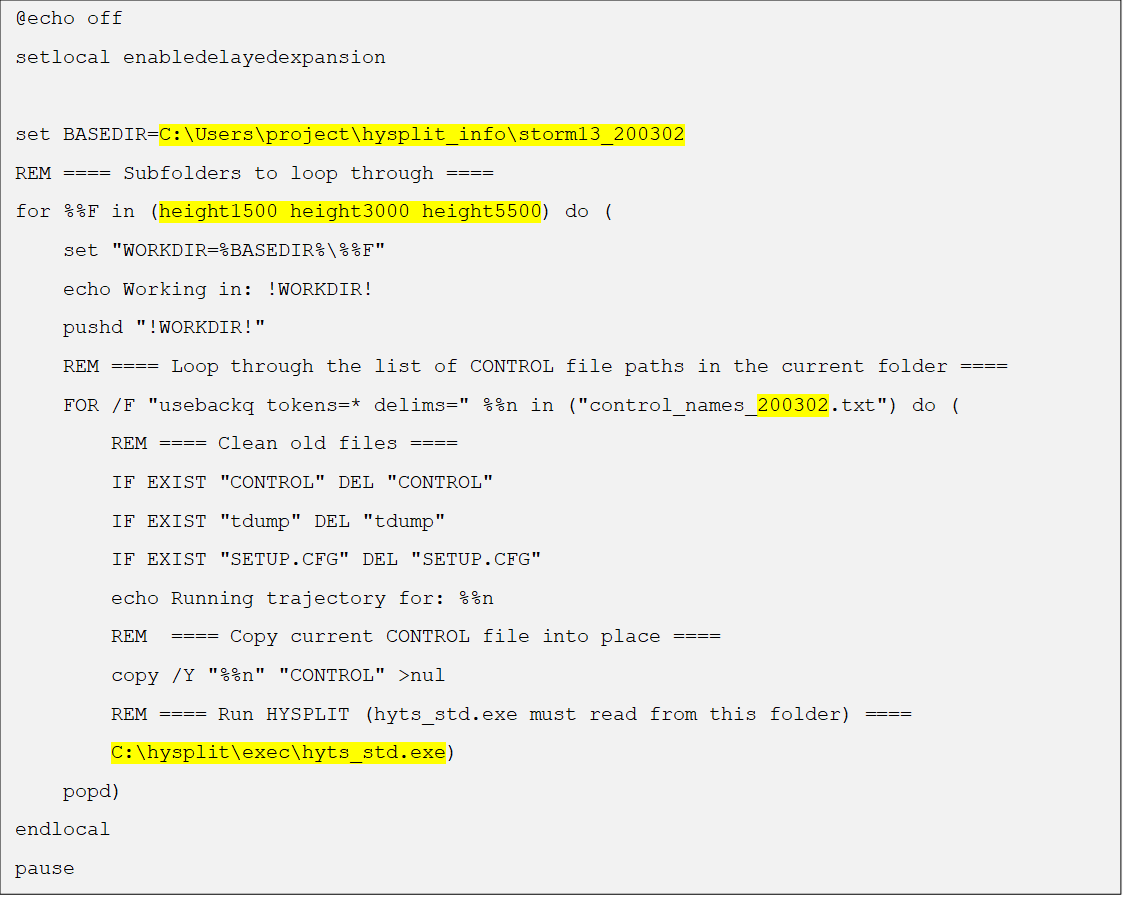

### HYSPLIT for a single level
If you want to run HYSPLIT for a single level, then use the batch file ``run_hysplit_singlelevel.bat``. Much of the inner workings here are the same as the multilevel version above. I’ve attached a copy of the batch file below, with the yellow highlighted sections being text to change depending on the storm. In order of appearance, here is how you should change it:
1)	You must cd to the folder for the storm and level you want to run HYSPLIT on. Change this every storm/level you run. 

2)	This must match the control_names file in each height folder. This means it must be changed with each storm (to match the year and month)

3)	This is a one time change, it is the folder that stores hyts_std.exe. If you used the default loading of HYSPLIT, this will not need any change for you.

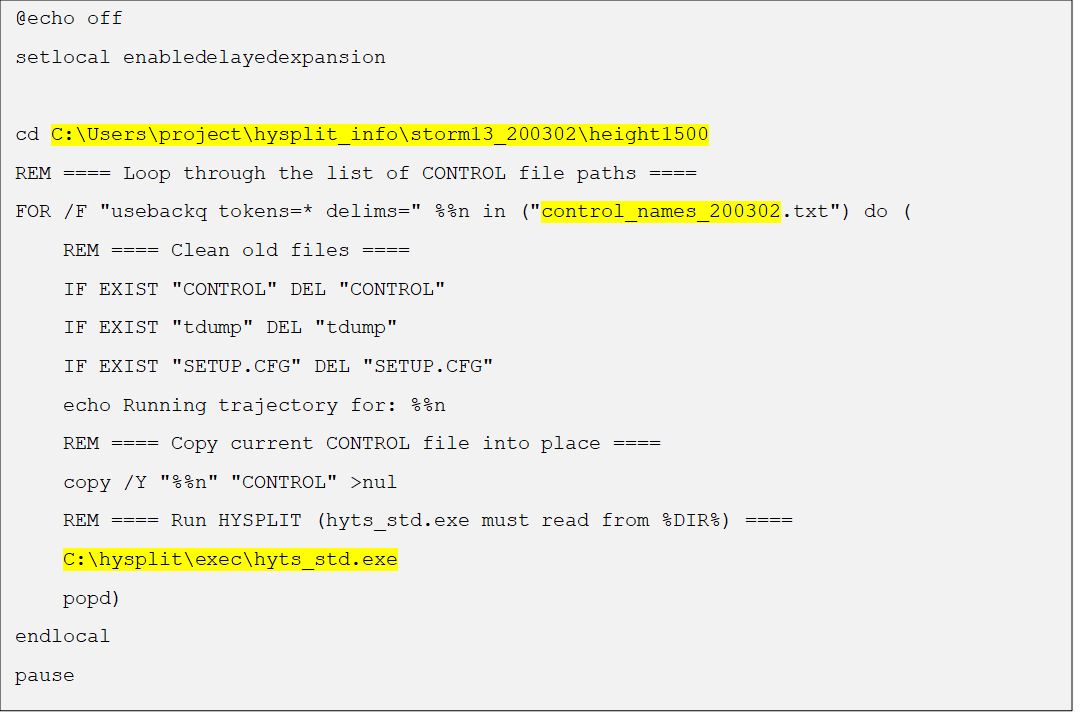

## Loading Trajectory Data
The load_tdump_files function reads HYSPLIT trajectory data from tdump files associated with a specific storm event (identified by their SID, date, and level). It uses a text file to located all the relevant tdump files, skips over metadata lines, and extracts trajectory data points (year, month, day, hour, latitude, longitude, height (m-AGL), and pressure), saving each trajectory as a NumPy array. All trajectories are returned as a list of arrays. Optionally, the function can call save_traj_npz to store the data in a compressed npz file, where each trajectory is assigned a unique traj_id. The npz files contains column names and trajectory data to make it easier to filter for individual trajectories during analysis. Together, these functions streamline the loading, formatting, and saving of HYSPLIT output files. 

In [ ]:
def save_traj_npz(traj_data, SID, year, month, level):
    """
    Saves HYSPLIT tdump trajectory data to a compressed .npz file with labeled columns. Each trajectory is assigned a
    numeric ID (`traj_id`) to enable separation and filtering when working with the stored data. The output .npz file 
    includes both the trajectory data and column labels as metadata. The traj_id is the same as the number after the final
    underscore in the control/tdump filename, for example, CONTROL_200302day02_hour09_0 will have traj_id = 0. 

    Parameters:
        - storm_data = [list]; a list of arrays, where each array is a HYSPLIT trajectory
        - SID, year, month = [int, int, int]; storm identifiers
        - level = [int]; height above ground level (in meters) being inspected
    
    Creates:
        - A .npz file with the columns [traj_id, year, month, day, hour, lat, lon, height, pressure] where each
            trajectory has a different traj_id. This file is saved as 
            ``traj_data_storm{SID}_{year}{month}/traj_storm{SID}_height{level}m.npz``
            
    """
    print("Saving files...")
    month = str(month).zfill(2)
    
    # creating directory to hold the npz file (if it doesn't already exist)
    output_dir = f"traj_data_storm{SID}_{year}{month}"
    os.makedirs(output_dir, exist_ok=True)

    all_data = []
    
    # for each trajectory, we add a column of the traj_id 
    for traj_id, traj_arr in enumerate(traj_data):
        # creating a column full of the appropriate id number
        id_column = np.full((traj_arr.shape[0], 1), traj_id, dtype=int)
        # attach to the trajectory information
        arr_with_id = np.hstack((id_column, traj_arr))
        all_data.append(arr_with_id)
    
    # define the column names and filename
    combined_data = np.vstack(all_data)
    column_names = ['traj_id', 'year', 'month', 'day', 'hour', 'lat', 'lon', 'height', 'pressure']
    out_path = os.path.join(output_dir, f"traj_storm{SID}_height{level}m.npz")

    # save file
    np.savez_compressed(out_path, data = combined_data, column_names = column_names, 
             SID = SID, year = year, month = month, level=level)

    print(f"Saved: {out_path}")

In [ ]:
def load_tdump_files(SID, year, month, level, metdata_number, save_as_npz = True):
    '''
    Loads the trajectory information from the tdump files generated by HYSPLIT. The function accesses the text file holding
    all the tdump filenames, opens each one, and parses through each line to save the generated trajectory. If desired,
    the function will call `save_traj_npz` to save the trajectory information in an .npz file. 
    
    Inputs:
        - SID, year, month = [int, int, int]; storm identifiers
        - level = [int]; height above ground level (in meters) being inspected
        - metdata_number = [int]; the number of meterological files will be needed
                            - metdata_number = 1, if the storm starts more than run_hours after the start of the month 
        - save_as_npz = [bool]; if the user wants to save the data as a npz file
        
    Returns:
        - A list of arrays, where each array is a HYSPLIT trajectory   

    Notes:
        - If you changed the naming convention of the tdump files or directory, please change it here accordingly.
    '''    
    # each meteorological file has a line in the tdump files, so we need to filter out those extra lines and only save
    # the trajectory data
    row_with_trajinfo = metdata_number + 3

    print("Loading data....")
    month = str(month).zfill(2)
    # file that holds all the tdump names
    traj_filenames = f"storm{SID}_{year}{month}/height{level}/traj_files_{year}{month}.txt"
    
    level_trajectory = []
    # opening the text file that holds all the tdump names
    with open(f"hysplit_info/{traj_filenames}") as traj_names: 
        for traj_file in traj_names:
            
            # skip if it's an empty line
            if traj_file[:-1] == " " or traj_file[:-1] == "":
                continue
                
            trajectory_points = []
            # open the tdump file
            with open(traj_file[:-1]) as file:
                # for each line in tdump file (that holds trajectory data)
                for i, line in enumerate(file):
                     if i > row_with_trajinfo: 
                        # saving as [year, month, day, hour, lat, lon, height(m-AGL), pressure]
                        points = [line[16:19], line[22:26], line[28:30], line[34:36], line[59:65], line[66:74], 
                                  line[77:83], line[84:-1]]
                        
                        # the year in the tdump file is 1 or 2 digits (3 for 2003, 95 for 1995)
                        # Pad the tdump value with zeros (3 → "03", 95 → "95") and combine it with the input year, 
                        # giving the full year
                        traj_year_suffix = int(points[0])
                        # if necessary, it goes into the previous century
                        if traj_year_suffix > int(str(year)[2:]):
                            year_val = str(int(str(year)[:2]) - 1) + str(traj_year_suffix).zfill(2)
                        else:
                            year_val = str(year)[:2] + str(traj_year_suffix).zfill(2)
                        
                        # recombine with the points to have a 4-digit year in the first column
                        points = [year_val] + points[1:]
                
                        trajectory_points.append(points)
            
            # turn into array
            trajectory_points = np.array(trajectory_points).reshape(len(trajectory_points), len(points)).astype('float')
            # append each array into the overall storage list
            level_trajectory.append(trajectory_points)
    
    if save_as_npz:
        # save in npz file
        save_traj_npz(level_trajectory, SID, year, month, level)
        
    return level_trajectory

## Finding moisture uptake parcels
The diagnose_moisture_uptakes function identifies when and where HYSPLIT air parcel trajectories experience a rapid increase in specific humidity (called a moisture uptake event in the Papritz paper) -- any hourly increase greater than 0.025 g/kg is marked as an uptake. These events are saved to one or more CSV files so that the diagnosis only needs to be done once, even if the kernel is reset. The function loads trajectories from a npz file, loops through each parcel, and checks for changes in humidity using get_dataset_for_time(). If no uptake events are found, the function returns the trajectory data. This makes it easier to manage large sets of storm data and track the sources of moisture in Arctic storms.

Since the moisture uptakes may be split into multiple CSV files, you can use the function `load_all_moisture_csvs()` to access all the CSVs at once to create an array of all the moisture uptakes. The primary function of splitting up the uptakes is avoiding a MemoryError, which can occur if you try to open an exceptionally large file in Python.

In [ ]:
def diagnose_moisture_uptakes(SID, YEAR, MONTH, level, nc_paths, rows_per_file=7500):
    """
    Diagnose moisture uptake parcels along HYSPLIT trajectories. A moisture uptake parcel has an hourly increase in 
    specific humidity greater than 0.025 g/kgh. After uploading the npz file with the trajectories, it goes through each
    point to find the change in specific humidity in the past hour. All uptake events are saved in an array and a series of 
    CSV files. 
    
    Inputs:
        - SID, YEAR, MONTH = [int, int, int]; storm identifiers
        - level = [int]; height above ground level (in meters) being inspected
        - nc_paths = [dict]; A dictionary with keys of var_types and values that are a list of tuples that are formatted
                                (filename, start_day, end_day)
        - rows_per_file = [int]; max number of rows per output CSV
        
    Returns:
        - uptake_event = [arr]; array of uptake events with shape (N, 8) for N uptake events found. The columns are 
                        [year, month, day, hour, lat, lon, height(m-AGL), pressure]. 
                        - if no uptake events are found, the data from the npz file is returned 
    
    Creates:
        CSV files holding the uptake events that were found. 
        
    Raises:
        - FileNotFoundError when `get_dataset_for_time` can't find a file for a given time, it will skip that time and move 
                            on. This maybe because the day is not represented in the nc files, the days are mislabelled, 
                            or there is an incorrectly written filepath.
        
    Notes:
        - This function uses `get_dataset_for_time` to find the values. 
        - Function used the npz files created from the back trajectories in `save_traj_npz`. If another naming/directory
          setup was used in creating these files, please adjust function accordingly.  
        - The moisture uptake CSV files can be accessed using `load_all_moisture_csvs`.
        
    """
    MONTH = str(MONTH).zfill(2)
    
    # === Loading the trajectory data ===
    print(f"Storm {SID}: {YEAR}/{MONTH} -- level {level}")
    #print("Opening trajectory data file")
    traj_path = f"traj_data_storm{SID}_{YEAR}{MONTH}/traj_storm{SID}_1200km_height{level}m.npz"
    datafile = np.load(traj_path)
    alldata = datafile["data"] # [traj_id, year, month, day, hour, lat, lon, height, pressure]

    if alldata.size == 0:
        print("No data found.")
        return []

    # Separating the trajectories using the ID
    ID = alldata[:, 0]
    _, indices = np.unique(ID, return_index=True)
    indices.sort()
    # Save in data array without the ID column (no longer useful after separating data)
    data = np.split(alldata[:, 1:], indices[1:]) 
    print(f"Found {len(data)} trajectories") 
    
    #data has columns [year, month, day, hour, lat, lon, height, pressure]

    uptake_event = []
    
    # === find uptake events ===
    for i, traj in enumerate(data):
        progress_interval = 100 if len(data) > 500 else 50
        if i % progress_interval == 0:
            print(f"Processing trajectory {i}, uptake events found: {len(uptake_event)}")

        for row in traj:
            year_val, month_val_int, day_val_int, hour_val_int, lat_val, lon_val, height_val, press_val = row
            # pad the day, hour, month values with zeros (4 → "04", 12 → "12")
            day_val = str(int(day_val_int)).zfill(2)
            hour_val = str(int(hour_val_int)).zfill(2)
            month_val = str(int(month_val_int)).zfill(2)

            # the current row's time
            time_val = np.datetime64(f'{year_val}-{month_val}-{day_val}T{hour_val}:00')
            
            # Get the previous hour time
            prevHour_val = (time_val - np.timedelta64(1, 'h'))

            try:
                # open the nc files for both time values
                with get_dataset_for_time(nc_paths, 'HumidityCWC', time_val) as ds, \
                     get_dataset_for_time(nc_paths, 'HumidityCWC', prevHour_val) as ds_prev:
                    
                    # Find indices of the time value, lat, lon, and pressure
                    time_ind = np.argmin(np.abs(ds.valid_time.values - time_val))
                    time_prev_ind = np.argmin(np.abs(ds_prev.valid_time.values - prevHour_val))
                    press_ind = np.argmin(np.abs(ds.pressure_level.values - press_val))
                    lat_ind = np.argmin(np.abs(ds.latitude.values - lat_val))
                    lon_ind = np.argmin(np.abs(ds.longitude.values - lon_val))

                    specific_humidity = ds['q'].isel(valid_time=time_ind, pressure_level=press_ind, 
                                     latitude=lat_ind, longitude=lon_ind).values.item()  # in kg/kg

                    specific_humidity_previous = ds_prev['q'].isel(valid_time=time_prev_ind, pressure_level=press_ind, 
                                     latitude=lat_ind, longitude=lon_ind).values.item()  # in kg/kg

                    if (specific_humidity - specific_humidity_previous) * 1000 >= 0.025: # check criteria for uptake
                        # save with the full year
                        uptake_info = [int(year_val), int(month_val_int), int(day_val_int), int(hour_val_int), 
                                       float(lat_val), float(lon_val), float(height_val), float(press_val)]
                        uptake_event.append(uptake_info)
            
            # skip time stamp if get_dataset_for_time can't find a time value
            except (FileNotFoundError):
                print(f"Skipping time {time_val} because no nc file was found")
                continue
    
    # if no uptake_events found
    if not uptake_event:
        print("No uptake events found. Exiting.")
        return data # returns data loaded from npz file
    
    uptake_event = np.array(uptake_event)
    print(f"Found {len(uptake_event)} moisture uptake events.")

    # === Save results ===
    # save in same directory as npz files
    output_dir = f"traj_data_storm{SID}_{YEAR}{MONTH}"
    os.makedirs(output_dir, exist_ok=True)
    file_base = f"moisture_uptake_storm{SID}_height{level}m"
    nrows = uptake_event.shape[0]
    # calculate number of files to be created
    # (if rows_per_file = 5000 and there are 7500 uptake events, there will be 2 files)
    num_chunks = (nrows + rows_per_file - 1) // rows_per_file
    header = "year, month, day, hour, lat, lon, height, pressure"

    print(f"Saving {num_chunks} CSV files...")
    for i in range(num_chunks):
        # define which rows to save
        start = i * rows_per_file
        end = min(start + rows_per_file, nrows)
        event_chunk = uptake_event[start:end]
        # define filename: will be differentiated by using part_ (starting from 1)
        filename = os.path.join(output_dir, f'{file_base}_part{i+1}.csv')
        np.savetxt(filename, event_chunk, header = header, delimiter=',', 
                   fmt=['%d','%d','%d','%d','%.6f','%.6f','%.2f','%.2f'])
        print(f"Saved {filename} with shape {event_chunk.shape}")
    
    return uptake_event

 To access the moisture uptake files, use the following function

In [ ]:
def load_all_moisture_csvs(SID, YEAR, MONTH, level):
    """
    Load all the moisture uptake CSVs associated with a particular storm and level. 
    
    Inputs:
        - SID, YEAR, MONTH = [int, int, int]; storm identifiers
        - level = [int]; height above ground level (in meters) being inspected
    
    Returns: 
        - Array of moisture uptakes with columns [year, month, day, hour, lat, lon, height, pressure]
    
    Raises:
        - FileNotFoundError if there are no files with that naming structure in the directory
        
    Notes:
        - If the naming/directory structure of the CSVs was changed at some point, please adjust here
        
    """
    MONTH = str(MONTH).zfill(2)
    
    # access files in folder
    folder_path = f"traj_data_storm{SID}_{YEAR}{MONTH}"
    pattern = os.path.join(
        folder_path, f"moisture_uptake_storm{SID}_height{level}m_part*.csv")
    files = sorted(glob.glob(pattern))
    
    # if no files are found
    if not files:
        raise FileNotFoundError("No moisture uptake CSV files found in {folder_path}")

    print(f"Loading {len(files)} moisture uptake files...")
    # put into an array
    arrays = [np.genfromtxt(f, delimiter=',', skip_header = 1) for f in files]
    return np.vstack(arrays)  

## Plotting
This section will provide sample code for a helper function and 3 different plots:

1) Draw a circle on a plot

2) A simple plot of a storm track

3) Two possible figures similar to Figure 3 in the Papritz paper (a moisture uptake footprint)

4) A figure similar to Figure 4 in the Papritz paper (HYSPLIT trajectories with changes in specific humidity)

Note that the last two plots will not exactly match Figures 3 and 4 in the Papritz paper but provides a good jumping off point for those plots. 

### Draw a circle on a plot
This function can be used to draw a circle on any plot around a center lat/lon with a given radius (in km). It is fairly self explanatory but is useful. It is used in creating figure 3 and 4. 

In [ ]:
def draw_circle(center_lon, center_lat, radius_km):
    '''
    To plot a circle around the center lon and lat with a specified radius. 
    
    Inputs:
    - center_lon, center_lat = [float, float]; where you want the circle to be centered
    - radius_km = [float]; radius of the circle in km
    
    Outputs:
    - circle_lons, circle_lats = [list, list]; a list of 
    ''''
    radius = radius_km*1000
    geod = Geod(ellps="WGS84")  # Use the WGS84 Earth model

    # Azimuths from 0 to 360 degrees
    azimuths = np.linspace(0, 360, 72)

    # Repeat the center point into arrays that match azimuths
    lons = np.full(azimuths.shape, center_lon)
    lats = np.full(azimuths.shape, center_lat)
    dists = np.full(azimuths.shape, radius)
    
    # Compute the circle (500 km radius)
    circle_lons, circle_lats, _ = geod.fwd(lons, lats, azimuths, dists)
    
    return circle_lons, circle_lats 

### Simple storm track plot
This will allow you to make a plot of a storm track, it is very barebones but can be easily customizable to fit your purposes. Please change SID, YEAR, MONTH to fit whatever your storm is. It plots the points that are outside the Arctic mask in black, and points within the Arctic mask as red. The starting point of the storm is a purple cross. You can use this base and plot multiple storms on the same map. Here, I'm assuming you're uploading the storm information from the CSV but this can be easily changed if you have the information in an array/list. 

In [ ]:
# change to fit your storm
SID, YEAR, MONTH = _, _, _
MONTH = str(MONTH).zfill(2)

# upload storm information
lats, lons, x, y = np.genfromtxt(fr"storm{SID}_{YEAR}{MONTH}.csv", usecols = (5, 6, 7, 8), delimiter = ',').T
x, y = x.astype(int), y.astype(int)

# define the arctic mask
inMask = np.array([CAO2[y[j], x[j]] == 1 for j in range(len(x))])

# set up figure
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())

# Map features
ax.gridlines(draw_labels=False, linestyle='dotted')
ax.add_feature(cfeature.COASTLINE, edgecolor='lightgrey', alpha=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgrey', alpha=.7)

# plot mask and storm
ax.pcolormesh(lon_mask, lat_mask, CAO2, transform=ccrs.PlateCarree(), cmap='Blues', alpha=0.2)
ax.scatter(lons[inMask], lats[inMask], transform=ccrs.Geodetic(), linewidths=.25, color='tab:red')
ax.scatter(lons[~inMask][1:], lats[~inMask][1:], transform=ccrs.Geodetic(), linewidths=.25, color='black')
ax.scatter(lons[0], lats[0], marker='X', transform=ccrs.Geodetic(), linewidths=1, color='tab:purple')

plt.show()

### Figure 3 in Papritz

If you want to plot a moisture uptake footprint like in the Papritz paper, use this code. You will need to have already found the moisture uptakes and saved them in CSVs using the functions in 'Finding moisture uptake parcels'. Additionally, you will need the precipitation, mean sea level pressure, and sea surface temperature. These should all be defined in the storm's nc_paths dictionary as this function uses `get_dataset_for_time()` to plot these variables as contours. I'm assuming you can access all three variables through a key ["precip_SST_SLP"]. If this isn't true, then you'll need to change the key name where "ds_precip_sst_msl" is defined. If the total precipitation is stored in a different key than the sea surface temperature and sea level pressure, then you should use `get_dataset_for_time()` to get that nc file when plotting it. These should all be defined in the storm's nc_paths dictionary as this function uses `get_dataset_for_time()` to plot these variables as contours. I have also defined the colourmaps that were used in the Papritz paper. 

The first function `moisture_uptake_plot_separate()` will make a 1x3 plot of the moisture uptakes associated with 3 timestamps. The key difference here is that this function will plot the storm as different timestamps than the Papritz paper. Here, t=0h is when the storm enters the Arctic (center panel). It will also make a plot for -24h (left panel) and +24h (right panel). Thus, these footprints will be centered around Arctic entry, rather than intensity. While this level of specificity can be good, it will fail if there are no moisture uptakes assocuated with any of the three timestamps. You can choose to plot single or multiple layers in one plot. Here is a sample of the resulting plot:
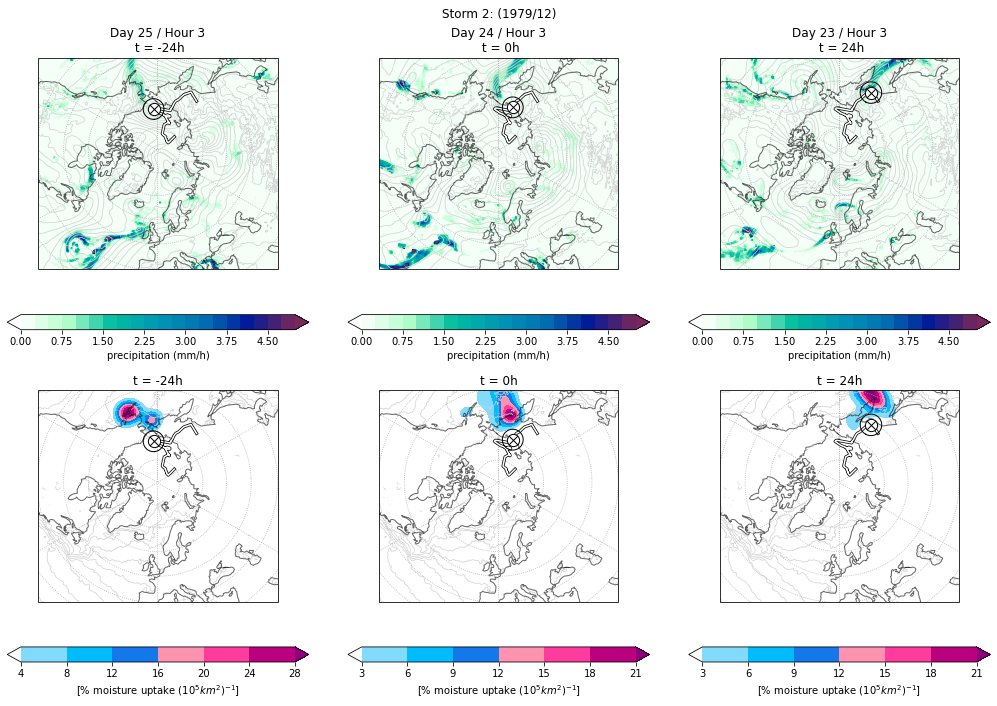

The second function `moisture_uptake_plot_together()` plots all of the moisture uptakes for a storm, regardless of time. You will not need the total precipitation, sea surface temperature, or sea level pressure for this. This gives you a look at the general shape of the storm uptakes, which is especially helpful if you have few moisture uptakes. Here is a sample of what the resulting plot will look like:
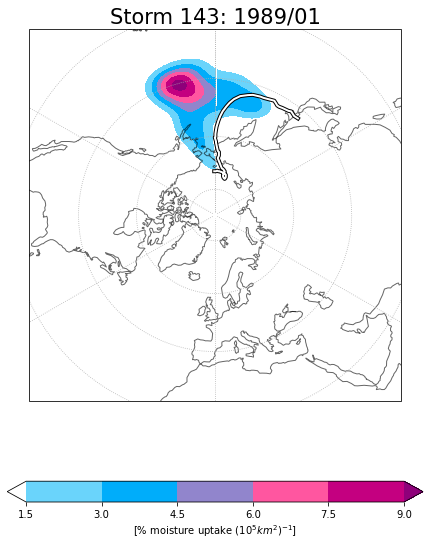
These are ALL the moisture uptakes (across all levels and times) for Storm 143 (1989/01). 

Much like the other functions, if the naming/sorting conventions of the moisture uptake information has changed, please change it in this function to avoid a FileNotFoundError. The main area to fix is the `load_all_moisture_csvs()`.

In [ ]:
# these are the colourmaps used in the Papritz paper
cols_uptakes = ["#FFFFFF", "#56cefb", "#00c5ff", "#00a2f7", "#1a69e4", "#ffa0b6", "#ff67a3", "#ff309b", "#cb0081", "#8e007a"]
cols_precip = ["#ffffff", "#b4ffcb", "#00be9f", "#0097b6", "#0071b4", "#00199a", "#7a285a"]

moisture_uptake_cmap = colors.LinearSegmentedColormap.from_list("moisture_uptake_colourmap", cols_uptakes)
precip_cmap = colors.LinearSegmentedColormap.from_list("precip_cmap", cols_precip)

def moisture_uptake_plot_separate(SID, YEAR, MONTH, nc_paths, levels):
    """
    Plot gridded moisture uptake footprint and storm diagnostics as three timestamps (t = -24h, 0h, 24h) where 0h is when
    the storm enters the Arctic. 
    
    The function will first upload all of the moisture uptakes associated with the level(s) you specify. Then, it creates
    a grid with dimensions (day/hour, lats, lons) and will grid the moisture uptakes. After smoothing using a Gaussian mean
    filter, the function will reshape the grid from 31^2 km^2 to 10^5 km^2 (matching the Papritz paper). Finally, it will
    plot the grids. 
    
    Inputs:
    - SID, YEAR, MONTH = [int, int, int]; storm identifiers
    - levels = [int]; height above ground level (in meters) being inspected
    - nc_paths = [dict]; A dictionary with keys of var_types and values that are a list of tuples that are formatted
                            (filename, start_day, end_day)
                            
    Creates:
    - a 1x3 plot of moisture uptakes at the timestamps (-24h, 0h, 24h)
    
    Notes:
    - This function uses the helper functions load_moisture_csvs and get_dataset_for_time
    
    """
    MONTH = str(MONTH).zfill(2)
    if isinstance(levels, int):
        levels = [levels]
        
    # Load storm path
    storm_path = f"storm{SID}_{YEAR}{MONTH}.csv"
    _, STORM_YEAR, STORM_MONTH, STORM_DAY, STORM_HOUR, _, _, STORM_X, STORM_Y = np.genfromtxt(storm_path, delimiter=',', 
                                                                                              dtype = int, skip_header = 1).T
    STORM_LAT, STORM_LON = np.genfromtxt(storm_path, delimiter = ',', usecols = (5, 6), skip_header = 1).T

    IN_MASK = np.array([(CAO2[STORM_Y[ind], STORM_X[ind]] == 1) for ind in range(len(STORM_X))]).astype('bool')
    
    # finding the timestamps
    idx_0h = np.argmax(IN_MASK)
    # since the time is recorded in 3 hour increments, ±24h is ±8 indices ahead 
    idx_fwd24h = idx_0h + 8
    idx_back24h = idx_0h - 8
    study_idx = [idx_fwd24h, idx_0h, idx_back24h]
   
    # A list of the (day, hour) combination of the 3 timestamps we're studying
    day_hour_combo = [(STORM_DAY[i], STORM_HOUR[i]) for i in study_idx]
    
    # upload the moisture uptake data
    data = []
    for level in levels:
        print(f"== Level {level} ==")
        level_data = load_all_moisture_csvs(SID, YEAR, MONTH, level)
        data.append(level_data[:, 2:]) # only saving the [day, hour, lat, lon, height, pressure] columns
        
    data = np.concatenate(data)
    
    # set up grids
    lats_range = np.arange(-90, 90, 0.5)
    lons_range = np.arange(-180, 180, 1)
    lon_grid, lat_grid = np.meshgrid(lons_range, lats_range)
    lat_size, lon_size = len(lats_range), len(lons_range)

    grid_ERA5 = np.zeros((3, lat_size, lon_size))
    smoothed_grid_ERA5 = np.zeros_like(grid_ERA5)
    norm_OGgrid_ERA5 = np.zeros_like(grid_ERA5)

    # Populate grid counts
    for row in data:  
        day, hour, lat_raw, lon_raw = int(row[0]), int(row[1]), row[2], row[3]
        lat, lon = math.floor(lat_raw * 4)/4, math.floor(lon_raw*4)/4
        # find the index location of the moisture uptake
        lat_idx = np.argmin(np.abs(lats_range - lat))
        lon_idx = np.argmin(np.abs(lons_range - lon))
        
        if (0 <= lat_idx < lat_size) and (0 <= lon_idx < lon_size) and (day, hour) in day_hour_combo:
            # find what the timestamp of the moisture uptake is
            day_idx = day_hour_combo.index((day, hour))
            grid_ERA5[day_idx, lat_idx, lon_idx] += 1
            
            
    # normalize each gridded count by the total counts at that day/hour 
    for d in range(len(grid_ERA5)):
        if np.sum(grid_ERA5[d]) == 0:
            norm_OGgrid_ERA5[d] = 0
        else:
            norm_OGgrid_ERA5[d] = (grid_ERA5[d] / np.sum(grid_ERA5[d]))*100 

    # apply mean filter
    for d in range(len(grid_ERA5)):
        # the size denotes what range to smooth over, here it is over 5deg grids
        smoothed_grid_ERA5[d] = gaussian_filter(norm_OGgrid_ERA5[d], sigma=5, mode='grid-wrap')

    # regridding from ERA5 31x31 km^2 resolution to target 10^5 km^2 resolution
    ERA5_res = 31**2
    target_res = 10**5
    norm_grid_ERA5 = smoothed_grid_ERA5 * target_res/ERA5_res

    plot_idx = np.concatenate((study_idx, study_idx))
    plot_day_hour = np.concatenate((day_hour_combo, day_hour_combo))
    pos_label = ["-24h", "0h", "24h", "-24h", "0h", "24h"]

    # define the plot
    fig, axs = plt.subplots(2, 3, figsize=(15, 10), subplot_kw={'projection': ccrs.NorthPolarStereo()}, layout='tight')
    axs = axs.flatten()
    fig.suptitle(f"Storm {SID}: ({YEAR}/{MONTH})", fontsize = 20)

    # === Per-hour plotting loop ===
    for i, (idx, day_hour, ax) in enumerate(zip(plot_idx, plot_day_hour, axs)):
        year, month = int(STORM_YEAR[idx]), int(STORM_MONTH[idx])
        day, hour = day_hour

        # check if the grid is empty for that time
        if max(norm_grid_ERA5[i%3].flatten()) < 1e-3:
            print(f"Skipping day {day}, hour {hour} because max is {max(norm_grid_ERA5[i%3].flatten())}")
            continue
        
        # find the circle around the storm center (500km radius)
        circle_lons, circle_lats = draw_circle(STORM_LON[idx], STORM_LAT[idx], 500) 
        
        # access the sea surface temperature (sst) and mean sea level pressure (msl) for the timestamp
        time_val = np.datetime64(f"{year}-{str(month).zfill(2)}-{str(day).zfill(2)}T{str(hour).zfill(2)}:00")
        ds_precip_sst_msl = get_dataset_for_time(nc_paths, "precip_SST_SLP", time_val)
        time_ind = np.argmin(np.abs(ds_precip_sst_msl.valid_time.values - time_val))
        sst = ds_precip_sst_msl.sst.values[time_ind]
        msl = ds_precip_sst_msl.msl.values[time_ind] * 0.01
        
        # find the plotting levels for the sst and msl
        levels_sst = np.arange(np.nanmin(sst), np.nanmax(sst), 3)
        levels_msl = np.arange(np.min(msl), np.max(msl), 5)
        ds_lon_grid, ds_lat_grid = np.meshgrid(ds_precip_sst_msl.longitude.values, ds_precip_sst_msl.latitude.values)

        # create figure labels
        if i < 3:
            ax.set_title(f"Day {day} / Hour {hour}\n t = {pos_label[i]}")
        else:
            ax.set_title(f"t = {pos_label[i]}")
    
        # add basic features (coastlines, gridlines, storm track, storm center, circle around center, extent)
        ax.add_feature(cfeature.COASTLINE, edgecolor='black', alpha=0.6, zorder = 2)
        ax.gridlines(draw_labels=False, linestyle='dotted') 
        ax.plot(STORM_LON, STORM_LAT, color = 'white', lw = 1.5, zorder = 3,
                path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()], transform = ccrs.Geodetic())            
        ax.scatter(STORM_LON[idx], STORM_LAT[idx], color = 'black', lw = 1, zorder = 5, marker = 'x', 
           transform = ccrs.Geodetic(), s = 75)
        ax.scatter(STORM_LON[idx], STORM_LAT[idx], facecolor = 'white', edgecolor = 'black', marker = "o",
           transform = ccrs.Geodetic(), zorder = 4, lw = 1, s = 150)
        ax.plot(circle_lons, circle_lats, transform=ccrs.Geodetic(), color='black', linestyle='-', linewidth=1, zorder = 3)
        ax.set_extent([-180, 180, 25.0, 90.0], crs=ccrs.PlateCarree())
    
        # in the top row, the plot has the precipitation and slp
        if i < 3:
            precip_levels = np.arange(0.0, 5.1, 0.25)
            # if the precipitation is saved in a separate nc file, access it here using this code:
            #ds_precip = get_dataset_for_time(nc_paths, "precip", time_val)
            # assuming that your precipitation and SST/SLP nc file follows the same grid/time limitations, just replace
            # ds_precip_sst_msl.tp.values[time_ind]*1000 below with ds_precip.tp.values[time_ind]*1000
            cn0 = ax.contourf(ds_lon_grid, ds_lat_grid, ds_precip_sst_msl.tp.values[time_ind]*1000, levels = precip_levels,
                                  cmap = precip_cmap, transform = ccrs.PlateCarree(), extend = 'both', zorder=1)
            fig.colorbar(cn0, orientation = 'horizontal', ax = ax, shrink = 0.8,
                         label = "precipitation (mm/h)")
            vc0 = ax.contour(ds_lon_grid, ds_lat_grid, ds_precip_sst_msl.msl.values[time_ind]*0.01, 
                                 levels = levels_msl, colors=['lightgrey'], linewidths = 0.75, transform=ccrs.PlateCarree(), zorder=1)        
        
        # in the bottom row, the plot has the moisture uptakes and sst
        else:
            cn1 = ax.contourf(lon_grid, lat_grid, norm_grid_ERA5[i%3], transform=ccrs.PlateCarree(), 
                                  cmap = moisture_uptake_cmap, extend = 'both', zorder = 1)
            fig.colorbar(cn1, orientation = "horizontal", ax = ax, shrink = 0.8,
                         label = r"[% moisture uptake $(10^{5} km^{2})^{-1}$]")

            vc1 = ax.contour(ds_lon_grid, ds_lat_grid, ds_precip_sst_msl.sst.values[time_ind], 
                                 levels = levels_sst, colors=['lightgrey'], linewidths = 0.75, transform=ccrs.PlateCarree(), zorder = 1)

    plt.show()

In [ ]:
# these are the colourmaps used in the Papritz paper
cols_uptakes = ["#FFFFFF", "#56cefb", "#00c5ff", "#00a2f7", "#1a69e4", "#ffa0b6", "#ff67a3", "#ff309b", "#cb0081", "#8e007a"]
moisture_uptake_cmap = colors.LinearSegmentedColormap.from_list("moisture_uptake_colourmap", cols_uptakes)

def moisture_uptake_plot_together(SID, YEAR, MONTH, levels):
    """
    Plots gridded moisture uptakes for all times for a particular time at specified levels. 
    
    The function will first upload all of the moisture uptakes associated with the level(s) you specify. Then, it creates
    a grid with dimensions (lats, lons) and will grid the moisture uptakes. After smoothing using a Gaussian mean
    filter, the function will reshape the grid from 31^2 km^2 to 10^5 km^2 (matching the Papritz paper). Finally, it will
    plot the grid. 
    
    Inputs:
    - SID, YEAR, MONTH = [int, int, int]; storm identifiers
    - levels = [int]; height above ground level (in meters) being inspected

    Creates:
    - a 1x1 plot of gridded moisture uptakes
    
    Notes:
    - This function uses the helper 'get_moisture_uptake_csvs'
    
    """
    if isinstance(levels, int):
        levels = [levels]
        
    MONTH = str(MONTH).zfill(2)
        
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 25, 90], crs=ccrs.PlateCarree())
    
    # Add title, coasts, and grids
    ax.set_title(f"Storm {SID}: {YEAR}/{MONTH}", fontsize = 21)
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', alpha=0.6, zorder = 2)
    ax.gridlines(draw_labels=False, linestyle='dotted') 

    # Load storm path
    STORM_YEAR, STORM_MONTH, STORM_DAY, STORM_HOUR, STORM_LAT, STORM_LON = np.genfromtxt(f"storm{SID}_{YEAR}{MONTH}.csv",
                                                                delimiter=',', skip_header = 1, usecols = range(1, 7)).T
    
    # plot storm track
    ax.plot(STORM_LON, STORM_LAT, color = 'white', lw = 2, zorder = 3,
            path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()], transform = ccrs.Geodetic())            
    
    data = []
    # Load moisture uptake data
    for level in levels:
        print(f"== Level {level} ==")
        level_data = load_all_moisture_csvs(SID, YEAR, MONTH, level)
        data.append(level_data[:, 2:]) # only saving the [day, hour, lat, lon, height, pressure] columns
        
    data = np.concatenate(data)
    
    # define the grid
    lats_range = np.arange(-90, 90, 0.5)
    lons_range = np.arange(-180, 180, 1)
    lon_grid, lat_grid = np.meshgrid(lons_range, lats_range)
    lat_size, lon_size = len(lats_range), len(lons_range)

    grid_ERA5 = np.zeros((lat_size, lon_size))

    # Populate grid counts
    for row in data:
        lat_raw, lon_raw = row[2], row[3]
        lat, lon = math.floor(lat_raw * 4)/4, math.floor(lon_raw*4)/4
        # find lat/lon indices
        lat_idx = np.argmin(np.abs(lats_range - lat))
        lon_idx = np.argmin(np.abs(lons_range - lon))
        grid_ERA5[lat_idx, lon_idx] += 1

    # Normalize
    norm_OGgrid_ERA5 = grid_ERA5 / np.sum(grid_ERA5) * 100

    # Filter
    smoothed_grid_ERA5 = gaussian_filter(norm_OGgrid_ERA5, sigma=5, mode='grid-wrap')

    # regridding from ERA5 31x31 km^2 resolution to target 10^5 km^2 resolution
    ERA5_res = 31**2
    target_res = 10**5
    norm_grid_ERA5 = smoothed_grid_ERA5 * target_res/ERA5_res
    
    # plot moisture uptakes
    cn1 = ax.contourf(lon_grid, lat_grid, norm_grid_ERA5, transform=ccrs.PlateCarree(), cmap = moisture_uptake_cmap, 
                      extend = 'both', zorder = 1)
    fig.colorbar(cn1, orientation = "horizontal", ax = ax, shrink = 0.75,
                 label = fr"[% moisture uptake $(10^{5} km^{2})^{{-1}}$]")
                
    plt.tight_layout()
    plt.show()

### Figure 4 in Papritz

If you want to plot the storm trajectories with scattered circles showing moisture uptakes, use this code. You will need to have already run HYSPLIT and found the trajectories to run this code. Much like the code for figure 3, this section includes code to plot with different timestamps (which is more similar to Papritz) and a single plot that combines all the data. 

The first function ``storm_trajectory_plot_separate()`` will make a 1x3 plot of the HYSPLIT trajectories associated with three timestamps. The three timestamps used here are the arctic entry time (when the system enters the Arctic domain), the midpoint of its Arctic residence time, and the final time. The function assumes that you have trajectories associated with these times. You can choose to plot single or multiple layers in one plot. The function also includes the mean sea level pressure associated with the timestamp, a circle representing a radius around the storm center, and a cross representing where the storm center was in the *previous* timestamp. Additionally, the function chooses a random location on each trajectory to find the 12-hour change in specific humidity and plots these. All of these elements are included in the Papritz plot. 
Here is a sample of the resulting plot:
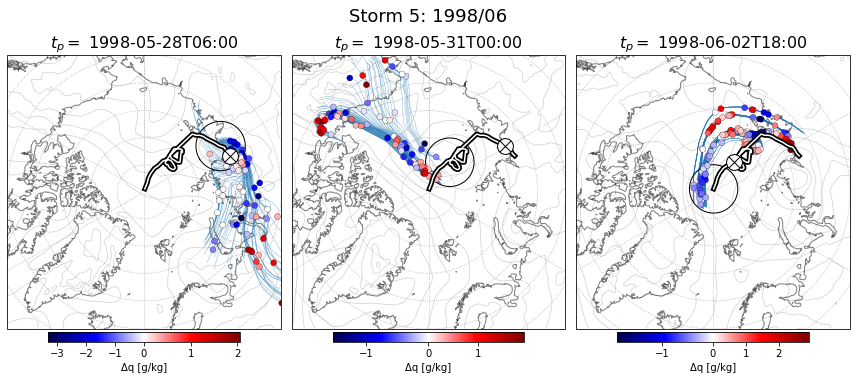


The second function ``storm_trajectory_plot_together()`` will create 1x1 plot that shows ALL trajectories, regardless of time and level. I primarily used this function because the storms I was working with did not have a sufficient number of trajectories to plot separate timestamps like in the Papritz paper. This function uses `get_dataset_for_time` to access the specific humidity. Feel free to work with this function to fit your purposes. Here is a sample of what the plot will look like:
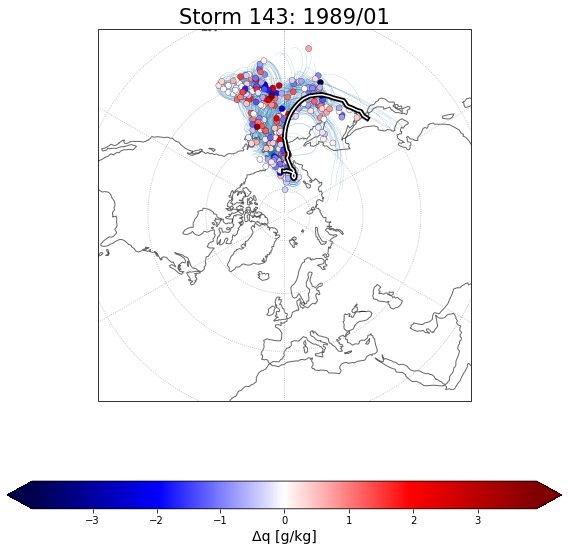
This is every 4th trajectory associated with Storm 143 (1989/01) across all levels and times. The scattered circles are 12-hour changes in specific humidity.

The function chooses a *random* value along the trajectory to find change in specific humidity for. This causes a more even distribution of points being plotted. However, you may miss a pattern in the data depending on your trajectory locations. Run the code a few times to check if there are any significant changes. 

A possible source of error in both the functions is with the TwoSlopeNorm function. If all of your Δq values are positive or negative, the function won't be able to define a diverging norm. In this case, it will simply plot without the normalization so Δq=0 will not be white. 

In [ ]:
def storm_trajectory_plot_separate(SID, YEAR, MONTH, nc_paths, levels, radius_km = 500):
    """
    Generate a 3-panel plot of a cyclone's trajectory and parcel moisture evolution.

    This function identifies three key timestamps along the cyclone’s trajectory:
        1. The Arctic entry time (when the cyclone first enters the Arctic domain),
        2. The midpoint of its Arctic residence,
        3. The final recorded time in the trajectory.
    The difference between these times is called Δt.

    For each of these times, a subplot is created showing:
        - The cyclone center and its circular radius (radius_km),
        - A cross marking the cyclone location at tp - Δt (before the selected time),
        - The storm trajectory path,
        - Mean sea level pressure (SLP) contours,
        - Precipitating parcel back-trajectories,
        - Dots indicating parcel-specific humidity changes (Δq) between tp–12h and tp.

        Inputs
        - SID, YEAR, MONTH = [int, int, int]; storm identifiers
        - nc_paths = [dict]; A dictionary with keys of var_types and values that are a list of tuples that are formatted
                            (filename, start_day, end_day)
        - levels = [int]; height above ground level (in meters) being inspected
        - radius_km = [int]; Radius of the plotted storm circle in kilometers (default = 500).
    
    Creates:
        - matplotlib figure with 3 subplots corresponding to the chosen timestamps.
    """

    MONTH = str(MONTH).zfill(2)
    if isinstance(levels, int):
        levels = [levels]
    
    # == finding the main storm trajectory and location ==
    _, STORM_YEAR, STORM_MONTH, STORM_DAY, STORM_HOUR, STORM_LAT, STORM_LON, STORM_X, STORM_Y = np.genfromtxt(f"storm{SID}_{YEAR}{MONTH}.csv",
                                                                                            delimiter=',', skip_header = 1).T
    # Convert storm metadata to integers for indexing
    STORM_YEAR, STORM_MONTH, STORM_DAY, STORM_HOUR, STORM_X, STORM_Y = map(lambda x: x.astype('int64'),
        [STORM_YEAR, STORM_MONTH, STORM_DAY, STORM_HOUR, STORM_X, STORM_Y])
    IN_MASK = np.array([(CAO2[STORM_Y[ind], STORM_X[ind]] == 1) for ind in range(len(STORM_X))]).astype('bool')
    
    # --- Define reference times: entry, midpoint, and end ---
    enter_arctic = np.argmax(IN_MASK)
    storm_end = len(IN_MASK)-1
    middle_time = (storm_end - enter_arctic) // 2 + enter_arctic
    
    idx_tp = [enter_arctic, middle_time, storm_end]
    tp_times = []
    
    for idx in idx_tp:
        y = STORM_YEAR[idx]
        m, d, h = map(lambda x: str(x).zfill(2), [STORM_MONTH[idx], STORM_DAY[idx], STORM_HOUR[idx]])
        timestamp = np.datetime64(f"{y}-{m}-{d}T{h}:00")
        tp_times.append(timestamp)
        
    # define cross locations
    idx_diff = middle_time - enter_arctic
    idx_tx = idx_tp - idx_diff  
    idx_tx = np.where(idx_tx < 0, 0, idx_tx)

    data_list = []    
    # --- Load precipitating parcel trajectory data for each vertical level ---
    print("Opening trajectory data file")
    for level in levels:
        traj_path = f"traj_data_storm{SID}_{YEAR}{MONTH}/traj_storm{SID}_height{level}m.npz"
        datafile = np.load(traj_path)
        alldata = datafile["data"]                   

        if alldata.size == 0:
            print("No data found.")

        ID = alldata[:, 0]
        _, indices = np.unique(ID, return_index=True)
        indices.sort()
        level_data = np.split(alldata[:, 1:], indices[1:])  # Skip ID column 
            
        for traj in level_data: #[year, month, day, hour, lat, lon, height, pressure]
            data_list.append(traj)

    data = np.array(data_list)
    
    # Create the figure
    fig, axs = plt.subplots(1, 3, figsize=(12, 5.5), 
                            subplot_kw={'projection': ccrs.NorthPolarStereo()}, constrained_layout=False)
    fig.subplots_adjust(top=0.92, bottom=0.08, left=0.05, right=0.95)
    fig.suptitle(f"Storm {SID}: {YEAR}/{MONTH}", fontsize = 18)
    
    # --- Loop over 3 reference times and create subplots ---
    for j, (tp_val, ax) in enumerate(zip(tp_times, axs)):   
        day_tp, hour_tp = tp_val.item().day, tp_val.item().hour
        # Define the time 12h earlier for Δq calculation
        tp_minus12h_val = (tp_val - np.datetime64(12, "h")).astype("datetime64")
        # Extract humidity data at tp and tp-12h
        ds = get_dataset_for_time(nc_paths, 'HumidityCWC', tp_val)
        ds_prev = get_dataset_for_time(nc_paths, 'HumidityCWC', tp_minus12h_val)
        
        delta_q_arr = []
        for arr_num, arr in enumerate(data):  #[year, month, day, hour, lat, lon, height, pressure]
            # if the trajectory starts at that day/hour
            if (arr[0, 2] == day_tp) and (arr[0, 3] == hour_tp):
                # plot trajectory
                ax.plot(arr[:, 5], arr[:, 4], transform=ccrs.Geodetic(), color='tab:blue', alpha=0.5, lw=0.5)                
                # choose a location to save 
                random_idx = random.randint(0, len(arr)-1)
                lat_val, lon_val, press_val = arr[random_idx, 4], arr[random_idx, 5], arr[random_idx, 7]

                # Find change in humidity                   
                # Find indices
                time_ind = np.argmin(np.abs(ds.valid_time.values - tp_val))
                time_prev_ind = np.argmin(np.abs(ds_prev.valid_time.values - tp_minus12h_val))
                press_ind = np.argmin(np.abs(ds.pressure_level.values - press_val))
                lat_ind = np.argmin(np.abs(ds.latitude.values - lat_val))
                lon_ind = np.argmin(np.abs(ds.longitude.values - lon_val))

                q = ds['q'].isel(valid_time=time_ind, pressure_level=press_ind,
                    latitude=lat_ind, longitude=lon_ind).values.item()

                q_prev = ds_prev['q'].isel(valid_time=time_prev_ind, pressure_level=press_ind,
                    latitude=lat_ind, longitude=lon_ind).values.item()

                # save the change in specific humidity
                delta_q = (q - q_prev)*1000
                delta_q_arr.append([lon_val, lat_val, delta_q])
                
        print(f"{len(delta_q_arr)} trajectories found")
        delta_q_arr = np.array(delta_q_arr)
        
        # map features
        ax.gridlines(draw_labels=False, linestyle='dotted')
        ax.add_feature(cfeature.COASTLINE, edgecolor='black', alpha=0.5) 
        ax.set_title(fr"$t_p = $ {tp_val}", va = 'top', fontsize = 16)
        ax.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())

        # main storm track
        ax.plot(STORM_LON, STORM_LAT, color = 'white', lw = 1.5, zorder = 4, transform = ccrs.Geodetic(),
        path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()])
        
        # --- Plotting: cyclone track, circle, pressure contours, Δq dots ---
        CROSS_LAT, CROSS_LON = STORM_LAT[idx_tx[j]], STORM_LON[idx_tx[j]]
        CIRCLE_LON, CIRCLE_LAT = draw_circle(STORM_LON[idx_tp[j]], STORM_LAT[idx_tp[j]], radius_km)
        ax.scatter(CROSS_LON, CROSS_LAT, color = 'black', lw = 1, zorder = 6, marker = 'x', 
                   transform = ccrs.Geodetic(), s = 125) # cyclone location cross
        ax.scatter(CROSS_LON, CROSS_LAT, facecolor = 'white', edgecolor = 'black', marker = "o",
                   transform = ccrs.Geodetic(), zorder = 5, lw = 1, s = 250)
        ax.plot(CIRCLE_LON, CIRCLE_LAT, transform = ccrs.Geodetic(), linewidth=1, color='black') # storm radius circle

        # plot mean sea level pressure
        with get_dataset_for_time(nc_paths, "SST_SLP", tp_val) as ds_sst_slp:
            msl_time_ind = np.argmin(np.abs(ds_sst_slp.valid_time.values - tp_val))
            msl = ds_sst_slp.msl.values[msl_time_ind] * 0.01
            levels_msl = np.arange(np.min(msl), np.max(msl), 5)
            ds_lon_grid, ds_lat_grid = np.meshgrid(ds_sst_slp.longitude.values, ds_sst_slp.latitude.values)

            vc0 = ax.contour(ds_lon_grid, ds_lat_grid, ds_sst_slp.msl.values[msl_time_ind]*0.01, 
                                levels = levels_msl, colors=['lightgrey'], linewidths = 0.75, 
                                 transform=ccrs.PlateCarree(), zorder=1)         
            
        try: # define a diverging colourmap
            divnorm = colors.TwoSlopeNorm(vmin=min(delta_q_arr[:, 2]), vcenter=0, vmax=max(delta_q_arr[:, 2]))
            # plot the delta q values
            sc = ax.scatter(delta_q_arr[:, 0], delta_q_arr[:, 1], c = delta_q_arr[:, 2], cmap='seismic', 
                                transform=ccrs.Geodetic(), linewidths=0.25, edgecolor='black', zorder = 3, norm = divnorm)

        except: # if the function can't create a diverging colourbar
            # plot the delta q values
            sc = ax.scatter(delta_q_arr[:, 0], delta_q_arr[:, 1], c = delta_q_arr[:, 2], cmap='seismic', 
                                transform=ccrs.Geodetic(), linewidths=0.25, edgecolor='black', zorder = 3)

        cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.01, shrink=0.7)
        cbar.set_label("Δq [g/kg]")
            
            
    plt.tight_layout()
    plt.show()

In [ ]:
def storm_trajectory_plot_together(SID, YEAR, MONTH, nc_paths, levels, choosing_val = 4):
    '''
    Plots storm trajectories and changes in specific humidity (Δq) over 12 hours for random points along each trajectory
    for a given storm event.

    Inputs:
    - SID, YEAR, MONTH = [int, int, int]; storm identifiers
    - nc_paths = [dict]; A dictionary with keys of var_types and values that are a list of tuples that are formatted
                            (filename, start_day, end_day)
    - levels = [int]; height above ground level (in meters) being inspected
    - choosing_val = [int]; Sampling rate for the parcel trajectories. Every `choosing_val`th trajectory will be plotted.
        Default is 4.

    Notes:
    ------
    - Requires storm track CSV and corresponding trajectory `.npz` files.
    - Assumes existence of a helper function `get_dataset_for_time(nc_paths, var_name, time)` 
      to load NetCDF datasets.   
    '''
    if isinstance(levels, int):
        levels = [levels]
        
    MONTH = str(MONTH).zfill(2)
    delta_q_arr = []
    
    # define figure
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 25, 90], crs=ccrs.PlateCarree())
    
    # Add title, coasts, and grids
    ax.set_title(f"Storm {SID}: {YEAR}/{MONTH}", fontsize = 21)
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', alpha=0.6, zorder = 2)
    ax.gridlines(draw_labels=False, linestyle='dotted') 
    
    # finding the main storm trajectory and location 
    STORM_YEAR, STORM_MONTH, STORM_DAY, STORM_HOUR, STORM_LAT, STORM_LON = np.genfromtxt(f"storm{SID}_{YEAR}{MONTH}.csv",
                                                                    delimiter=',', skip_header = 1, usecols = range(1, 7)).T
    # Convert date/time data to integers
    STORM_YEAR, STORM_MONTH, STORM_DAY, STORM_HOUR = map(lambda x: x.astype('int64'),
        [STORM_YEAR, STORM_MONTH, STORM_DAY, STORM_HOUR])
    
    # plot storm track
    ax.plot(STORM_LON, STORM_LAT, color = 'white', lw = 1.5, zorder = 4,
                path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()], 
                transform = ccrs.Geodetic())
        
    data_list = []
    # == getting the trajectories from the precipitating parcels ==  
    for level in levels:
        traj_path = f"traj_data_storm{SID}_{YEAR}{MONTH}/traj_storm{SID}_height{level}m.npz"
        
        # load trajectory data
        datafile = np.load(traj_path)
        alldata = datafile["data"]                   
        if alldata.size == 0:
            print("No data found.")
        
        # separate trajectories by ID
        ID = alldata[:, 0]
        _, indices = np.unique(ID, return_index=True)
        indices.sort()
        level_data = np.split(alldata[:, 1:], indices[1:])  # Skip ID column 
        
        #columns: [year, month, day, hour, lat, lon, height, pressure]
        for traj_num, traj in enumerate(level_data):
            if traj_num % choosing_val == 0:
                # Plot trajectory
                ax.plot(traj[:, 5], traj[:, 4], transform=ccrs.Geodetic(), color='tab:blue', alpha=0.5, lw=0.25)

                # Choose a random point on the trajectory
                random_idx = random.randint(0, len(traj) - 1)
                year_val, month_val, day_val, hour_val, lat_val, lon_val, _, press_val = traj[random_idx]
                
                # Format datetime values
                year_str = str(int(year_val))
                month_str = str(int(month_val)).zfill(2)
                day = str(int(day_val)).zfill(2)
                hour = str(int(hour_val)).zfill(2)
                time_val = np.datetime64(f"{year_str}-{month_str}-{day}T{hour}:00")
                time_minus12h_val = time_val - np.timedelta64(12, "h")

                # Load current and previous (12-hour earlier) humidity datasets
                with get_dataset_for_time(nc_paths, 'HumidityCWC', time_val) as ds, \
                     get_dataset_for_time(nc_paths, 'HumidityCWC', time_minus12_val) as ds_prev:

                    # Find nearest indices for time, pressure, lat, lon
                    time_ind = np.argmin(np.abs(ds.valid_time.values - time_val))
                    time_prev_ind = np.argmin(np.abs(ds_prev.valid_time.values - time_minus12h_val))
                    press_ind = np.argmin(np.abs(ds.pressure_level.values - press_val))
                    lat_ind = np.argmin(np.abs(ds.latitude.values - lat_val))
                    lon_ind = np.argmin(np.abs(ds.longitude.values - lon_val))

                    # Retrieve specific humidity at both times
                    q = ds['q'].isel(valid_time=time_ind, pressure_level=press_ind,
                                     latitude=lat_ind, longitude=lon_ind).values.item()
                    q_prev = ds_prev['q'].isel(valid_time=time_prev_ind, pressure_level=press_ind,
                                               latitude=lat_ind, longitude=lon_ind).values.item()

                    # Store the change in specific humidity (Δq in g/kg)
                    delta_q = (q - q_prev) * 1000
                    delta_q_arr.append([lon_val, lat_val, delta_q])


    delta_q_arr = np.array(delta_q_arr)
    print(f"{len(delta_q_arr)} trajectory found")  
    
    try:
        # define a diverging colourmap
        divnorm = colors.TwoSlopeNorm(vmin=min(delta_q_arr[:, 2]), vcenter=0, vmax=max(delta_q_arr[:, 2]))
        # plot the delta q values
        sc = ax.scatter(delta_q_arr[:, 0], delta_q_arr[:, 1], c = delta_q_arr[:, 2], cmap='seismic', 
                            transform=ccrs.Geodetic(), linewidths=0.25, edgecolor='black', zorder = 3, norm = divnorm)
        
    except: # if the function can't create a diverging colourbar
        # plot the delta q values
        sc = ax.scatter(delta_q_arr[:, 0], delta_q_arr[:, 1], c = delta_q_arr[:, 2], cmap='seismic', 
                            transform=ccrs.Geodetic(), linewidths=0.25, edgecolor='black', zorder = 3)
        
    cbar = plt.colorbar(sc, orientation = "horizontal", ax = ax, shrink = 1, extend = 'both')
    cbar.set_label("Δq [g/kg]", fontsize = 14)     
    
    plt.tight_layout()
    plt.show()

## Conclusion

This manual has outlined the main components of the code used to analyze moisture uptake in Arctic storms using HYSPLIT back trajectories and ERA5 reanalysis data. By following the structure and explanations provided, users should be able to load trajectory data, extract relevant environmental variables, and identify where and when moisture enters the storm system using changes in specific humidity. Many of the functions are modular and reuseable, making it easier to adapt the workflow to new storms, datasets, variables, and search radii. If any issues arise, such as missing files, unexpected errors, or unfamiliar output, double-check that the input files are formatted currently and refer to the function docstrings and manual for the clarification. Additionally, reading online forums helped my process. If necessary, please email me at kripa.vyas@mail.mcgill.ca. With this setup, you can now follow Papritz’s method for diagnosing moisture uptake. 
